**Actividad 3 – Evidencia de aprendizaje (EA3). Proyecto Integrador**

**Presentado por: Diego Barros Ballestas**

Link de acceso al video

Click [**Aquí**](https://drive.google.com/drive/folders/1p1OUYpkrF6s1OSlBBbxxHhByNvOg9tjv?usp=sharing) para ver el video explicativo



**Carga de datos en un Dataframe**

In [0]:
 # 1. Cargar los datos desde el archivo CSV en un DataFrame de Spark
dataf = (
    spark.read
    .option("header", True)  # Indice de l archivo tiene encabezados
    .option("inferSchema", True)  # tipos de datos
    .csv("/Workspace/Users/diego.barros@est.iudigital.edu.co/Big_Data/laptop_cleaned2.csv")  # Ruta del archivo
)

display(dataf.limit(10))

_c0,Name,Brand,Price,Rating,Processor_brand,Processor_name,Processor_variant,Processor_gen,Core_per_processor,Total_processor,Execution_units,Low_Power_Cores,Energy_Efficient_Units,Threads,RAM_GB,RAM_type,Storage_capacity_GB,Storage_type,Graphics_name,Graphics_brand,Graphics_GB,Graphics_integreted,Display_size_inches,Horizontal_pixel,Vertical_pixel,ppi,Touch_screen,Operating_system
0,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen 5 5600H/ 8GB/ 512GB SSD/ Win11/ 4GB Graph),HP,50399,4.3,AMD,AMD Ryzen 5,5600H,5.0,6.0,null,null,0.0,0,12.0,8,DDR4,512,SSD,AMD Radeon RX 6500M,AMD,4.0,false,15.6,1920,1080,141.21,true,Windows 11 OS
1,Lenovo V15 G4 ‎82YU00W7IN Laptop (AMD Ryzen 3 7320U/ 8GB/ 512GB SSD/ Win11 Home),Lenovo,26690,4.45,AMD,AMD Ryzen 3,7320U,7.0,4.0,null,null,0.0,0,8.0,8,LPDDR5,512,SSD,AMD Radeon Graphics,AMD,null,false,15.6,1920,1080,141.21,false,Windows 11 OS
2,HP 15s-fq5007TU Laptop (12th Gen Core i3/ 8GB/ 512GB SSD/ Win11 Home),HP,37012,4.65,Intel,Intel Core i3,1215U,12.0,6.0,2.0,4.0,0.0,0,8.0,8,DDR4,512,SSD,Intel UHD Graphics,Intel,null,false,15.6,1920,1080,141.21,false,Windows 11 OS
3,Samsung Galaxy Book2 Pro 13 Laptop (12th Gen Core i5/ 16GB/ 512GB SSD/ Win11),Samsung,69990,4.75,Intel,Intel Core i5,1240P,12.0,12.0,4.0,8.0,0.0,0,16.0,16,LPDDR5,512,SSD,Intel Iris Xe Graphics,Intel,null,false,13.3,1080,1920,165.63,false,Windows 11 OS
4,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8GB/ 512GB SSD/ Win11 Home),Tecno,23990,4.25,Intel,Intel Core i3,1115G4,11.0,2.0,null,null,0.0,0,4.0,8,LPDDR4,512,SSD,Intel UHD Graphics,Intel,null,false,15.6,1920,1080,141.21,false,Windows 11 OS
5,Samsung Galaxy Book2 NP550XED-KA1IN 15 Laptop (12th Gen Core i5/ 8GB/ 512GB SSD/ Win11),Samsung,42990,4.35,Intel,Intel Core i5,1235U,12.0,10.0,2.0,8.0,0.0,0,12.0,8,LPDDR4,512,SSD,Intel Integrated UHD,Intel,null,true,15.6,1920,1080,141.21,false,Windows 11 OS
6,Xiaomi Redmi G Pro 2024 Gaming Laptop (14th Gen Core i9/ 16GB/ 1TB SSD/ Win11 Home/ RTX 4060),Xiaomi,102990,4.25,Intel,Intel Core i9,14900HX,14.0,24.0,8.0,16.0,0.0,0,32.0,16,DDR5,1000,SSD,NVIDIA GeForce RTX 4060,NVIDIA,8.0,false,16.1,2560,1600,187.51,false,Windows 11 OS
7,Dell Inspiron 3520 D560896WIN9B Laptop (12th Gen Core i3/ 8GB/ 512GB SSD/ Win11),Dell,33780,4.75,Intel,Intel Core i3,1215U,12.0,6.0,2.0,4.0,0.0,0,8.0,8,DDR4,512,SSD,Intel UHD Graphics,Intel,null,false,15.6,1920,1080,141.21,false,Windows 11 OS
8,HP 15s-fq5330TU Laptop (12th Gen Core i5/ 16GB/ 512GB SSD/ Win11 Home),HP,54990,4.0,Intel,Intel Core i5,1235U,12.0,10.0,2.0,8.0,0.0,0,12.0,16,DDR4,512,SSD,Intel Integrated Iris Xe,Intel,null,true,15.6,1920,1080,141.21,false,Windows 11 OS
9,Asus Vivobook 15 X1502ZA-EJ544WS Laptop (12th Gen Core i5/ 16GB/ 512GB SSD/ Win11),Asus,55980,4.55,Intel,Intel Core i5,12500H,12.0,12.0,4.0,8.0,0.0,0,16.0,16,DDR4,512,SSD,Intel Iris Xe,Intel,null,false,15.6,1920,1080,141.21,false,Windows 11 OS


**Limpieza: evidencia antes/después y normalización**

In [0]:
from pyspark.sql import functions as F, types as T, Window

# Limpieza y normalización de datos
# Normaliza la columna de categoría (marca) y limpia la columna de precio
dataf = dataf.withColumn(
    "categoria_clean",
    F.lower(F.trim("Brand"))
)
dataf = dataf.withColumn(
    "precio_clean",
    F.when((F.col("Price").isNull()) | (F.col("Price") < 0), None)
    .otherwise(F.col("Price")).cast(T.DoubleType())
)

# Imputa valores nulos en precio con la media
media_price = dataf.select(F.mean("precio_clean")).first()[0]
dataf = dataf.na.fill({"precio_clean": media_price})

# Elimina outliers usando el rango intercuartílico (IQR)
q25, q75 = dataf.approxQuantile("Price", [0.25, 0.75], 0.01)
iqr = q75 - q25
bajo, alto = q25 - 1.5 * iqr, q75 + 1.5 * iqr
dataf_limpio = dataf.filter((F.col("precio_clean") >= bajo) & (F.col("precio_clean") <= alto))

# Evidencia antes de limpiar
dataf_evidency = dataf.withColumnRenamed("Brand", "categoria_original").withColumnRenamed("Price", "precio_original")
display(dataf_evidency.select("categoria_original", "precio_original").limit(10))

# Evidencia después de limpiar
display(dataf_limpio.select("categoria_clean", "precio_clean").limit(10))

categoria_original,precio_original
HP,50399
Lenovo,26690
HP,37012
Samsung,69990
Tecno,23990
Samsung,42990
Xiaomi,102990
Dell,33780
HP,54990
Asus,55980


categoria_clean,precio_clean
hp,50399.0
lenovo,26690.0
hp,37012.0
samsung,69990.0
tecno,23990.0
samsung,42990.0
xiaomi,102990.0
dell,33780.0
hp,54990.0
asus,55980.0


**Transformaciones: columnas de fecha**

Para este caso el dataset escogido no cuenta con la columna fecha

In [0]:
# 7. Crear columna de fecha: si existe 'date', la convierte; si no, genera fechas consecutivas
if "date" in dataf_limpio.columns:
    dataf_limpio = dataf_limpio.withColumn("fecha", F.to_date("tmstmp"))
else:
    base = F.to_date(F.lit("2024-01-01"))  # Fecha base
    dataf_limpio = (
        dataf_limpio.withColumn("rn", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
        .withColumn("fecha", F.date_add(base, F.col("rn") - 1))  # Genera fechas consecutivas
        .drop("rn")
    )

# 8. Derivar columnas de fecha: año, mes, día, día de la semana y nombre del día
dataf_limpio = (
    dataf_limpio
    .withColumn("anio", F.year("fecha"))  # Año
    .withColumn("mes", F.month("fecha"))  # Mes
    .withColumn("dia", F.dayofmonth("fecha"))  # Día del mes
    .withColumn("dia_semana", F.expr("EXTRACT(DAYOFWEEK FROM fecha)").cast("int"))  # Día de la semana (1=Domingo)
    .withColumn("nombre_dia", F.date_format("fecha", "EEEE"))  # Nombre del día (Lunes, Martes, etc.)
)

# 9. Mostrar las columnas derivadas de fecha
display(
    dataf_limpio
    .select("fecha", "anio", "mes", "dia", "dia_semana", "nombre_dia")
    .limit(10))

fecha,anio,mes,dia,dia_semana,nombre_dia
2024-01-01,2024,1,1,2,Monday
2024-01-02,2024,1,2,3,Tuesday
2024-01-03,2024,1,3,4,Wednesday
2024-01-04,2024,1,4,5,Thursday
2024-01-05,2024,1,5,6,Friday
2024-01-06,2024,1,6,7,Saturday
2024-01-07,2024,1,7,1,Sunday
2024-01-08,2024,1,8,2,Monday
2024-01-09,2024,1,9,3,Tuesday
2024-01-10,2024,1,10,4,Wednesday


Tener las columnas fecha, año, mes, día, día de la semana y nombre_día es crucial para el análisis de patrones temporales, ya que nos permite segmentar y entender el comportamiento de datos (ventas, por marca en un tiempo determinado) en diferentes granularidades (diaria, semanal, mensual, anual). tambien nos permite identificar para casos de auditoria la fecha en que se realizó el reistro de los datos.

**Nueva tabla: resumen por mes**

In [0]:
# Agrupa los datos limpios por año y mes
# Calcula el número de registros, el promedio de precio y el número de categorías por cada grupo
summary_mensual = (
    dataf_limpio.groupBy("anio", "mes")
    .agg(
        F.count("*").alias("n_registros"),  # Cuenta el total de registros por mes
        F.round(F.avg("precio_clean"), 2).alias("precio_promedio"), # Calcula el promedio de monto por mes
        F.countDistinct("categoria_clean").alias("n_categorias")  # Cuenta categorías únicas por mes
    )
    #  Ordenacion para que la serie de tiempo tenga sentido
    .orderBy("anio", "mes")
)

summary_mensual.write.mode("overwrite").saveAsTable("summary")

display(summary_mensual)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


anio,mes,n_registros,precio_promedio,n_categorias
2024,1,31,56698.35,12
2024,2,29,69735.72,10
2024,3,31,67145.1,11
2024,4,30,64964.77,10
2024,5,31,73658.68,11
2024,6,30,68460.93,9
2024,7,31,80661.19,11
2024,8,31,67383.52,9
2024,9,30,65326.43,9
2024,10,31,83296.0,10


In [0]:
%sql
-- Evidencas
SELECT * FROM summary ORDER BY anio, mes LIMIT 10;

anio,mes,n_registros,precio_promedio,n_categorias
2024,1,31,56698.35,12
2024,2,29,69735.72,10
2024,3,31,67145.1,11
2024,4,30,64964.77,10
2024,5,31,73658.68,11
2024,6,30,68460.93,9
2024,7,31,80661.19,11
2024,8,31,67383.52,9
2024,9,30,65326.43,9
2024,10,31,83296.0,10


**Visualizaciones por agrupaciones categóricas (con librerías)**

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


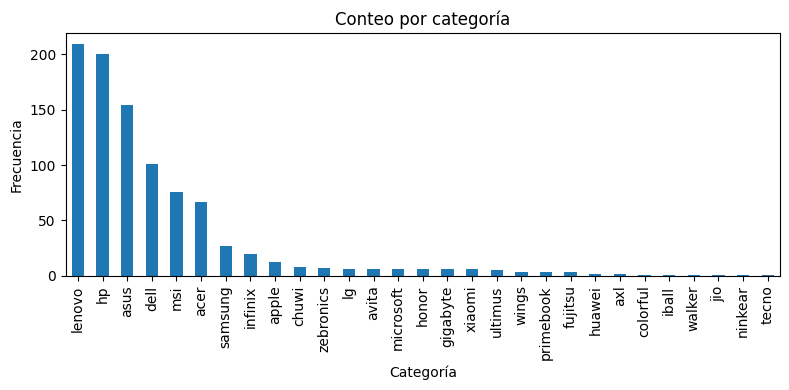

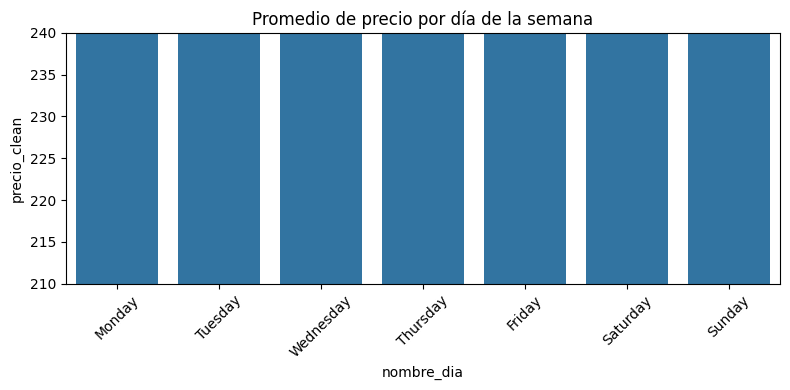

nombre_dia
Friday       66597.529851
Monday       68650.755556
Saturday     67059.768657
Sunday       67304.283582
Thursday     69344.455224
Tuesday      63888.074074
Wednesday    65487.214815
Name: precio_clean, dtype: float64


In [0]:
# Importa las librerías de visualización
import matplotlib.pyplot as plt  
import seaborn as sns           
import plotly.express as px     

# Convierte el DataFrame de Spark a Pandas para facilitar la visualización
pdframe = dataf_limpio.select(
    "categoria_clean", "precio_clean", "anio", "mes", "nombre_dia"
).toPandas()

# Gráfico de barras: muestra el conteo de registros por categoría limpia
plt.figure(figsize=(8,4))
conteo = pdframe["categoria_clean"].value_counts()
conteo.plot(kind="bar")
plt.title("Conteo por categoría") 
plt.xlabel("Categoría")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Gráfico de barras con Seaborn: muestra el promedio de precio por nombre de día
orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(8,4))

sns.barplot(
    data=pdframe, 
    x="nombre_dia", 
    y="precio_clean", 
    estimator="mean")

plt.ylim(210, 240)   
plt.title("Promedio de precio por día de la semana")  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Imprimimos los números
print(pdframe.groupby("nombre_dia")["precio_clean"].mean())



Para el grafico de barras representa el numeroi de registros de marca lo cual evidencia que las marcas mas populares en compra son: Lenovo, HP, Asus y Dell lo cual puede orientar la tendencias de compra de articulo.

Para los precios de venta promedio por dia de la semana se mantiene estable, se puede determinar que que los dias martes es de menor promedio de precio de venta lo cual piede indidir en dias de oferta.

**Grafica Interactiva**

In [0]:
import plotly.express as px

# 1.Agrupar los datos (Crear el resumen)
pdframe_resumen = (
    pdframe.groupby(["mes", "categoria_clean"])["precio_clean"]
    .mean()
    .reset_index()
    .sort_values("mes")
)

# 2. GRAFICAR EL RESUMEN
# Fíjate que aquí usamos 'pdf_resumen', NO 'pdf'
fig = px.bar(
    pdframe_resumen,      
    x="mes",
    y="precio_clean",
    color="categoria_clean",
    barmode="group",
    title="Precio promedio mensual por categoría"
)

display(fig)

Esta gráfica interactiva nos permiet entender el rpecio p´romedio mensual de venta de los laptos lo cual nos indica el movimiento de los articulos quue tuvieron mayor y menor precio promedio mensula dependiento del no de articulos comprados en el mes y el precio final